In [ ]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random

In [ ]:
os.makedirs('spectrograms3sec')
os.makedirs('spectrograms3sec/train')    #creating the folders for the taining set
os.makedirs('spectrograms3sec/test')     #creating the folder for the test set

In [ ]:
genres_musicaux = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [ ]:
for g in genres_musicaux:
  #creating the folders for each genre in order to store each song with it corresponding spectrogram
  path_audio = os.path.join('audio3sec',f'{g}')
  os.makedirs(path_audio)
  path_train = os.path.join('spectrograms3sec/train',f'{g}')
  path_test = os.path.join('spectrograms3sec/test',f'{g}')
  os. makedirs(path_train)
  os. makedirs(path_test)

In [ ]:
from pydub import AudioSegment
i = 0
for g in genres_musicaux:
  #splitting each song in 10 (10x3 seconds) in order to have a better accuracy (seen in a blog)
  j=0
  print(f'{g}')
  for filename in os.listdir(os.path.join('Data/genres_original',f'{g}')):
      song = os.path.join(f'Data/genres_original/{g}',f'{filename}')
      j += 1
      if filename == f'{g}' +'.00054.wav' :     #error with one file so we decide to supress 
        continue                           #one file per type to have an equal dataset
      else : 
        for w in range(0,10):
          i +=1
          t1 = 3*(w)*1000
          t2 = 3*(w+1)*1000
          newAudio = AudioSegment.from_wav(song)
          new = newAudio[t1:t2]
          new.export(f'audio3sec/{g}/{g+str(j)+str(w)}.wav', format='wav')


blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


blues
classical


KeyboardInterrupt: 

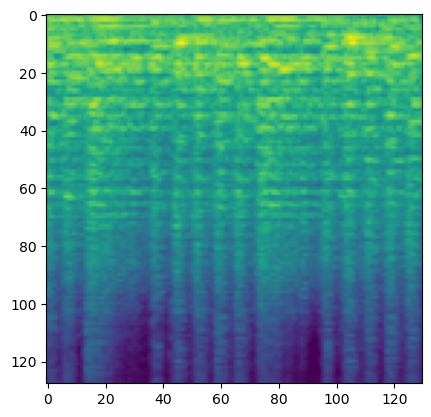

In [ ]:
for g in genres_musicaux:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('audio3sec',f'{g}')):
    if not filename.startswith('.'):     #avoiding the .DS_Store file
        song  =  os.path.join(f'audio3sec/{g}',f'{filename}')
        j += 1

        y,sr = librosa.load(song,duration=3)
        mels = librosa.feature.melspectrogram(y=y,sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
        plt.savefig(f'spectrograms3sec/train/{g}/{g+str(j)}.png')

In [ ]:
for g in genres_musicaux:
  filenames = os.listdir(os.path.join('spectrograms3sec/train/',f'{g}'))
  random.shuffle(filenames)
  test_files = filenames[0:149]

  for f in test_files:

    shutil.move('spectrograms3sec/train/' + f'{g}'+ '/' + f,'spectrograms3sec/test/' + f'{g}')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('spectrograms3sec/train/',target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)


validation_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = validation_datagen.flow_from_directory('spectrograms3sec/test/',target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

In [ ]:
def GenreModel(input_shape = (288,432,4),classes=10):
  
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)
  
  X = Dropout(rate=0.3)

  X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  
model = GenreModel(input_shape=(288,432,4),classes=10)
opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1]) 

model.fit_generator(train_generator,epochs=70,validation_data=vali_generator)